# Conditional FitzHugh-Nagumo model (partially observed)

In [1]:
%load_ext autoreload
%autoreload 2

In [168]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
from flax import nnx

from neuralbridge.sdes.examples import FHNSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedProposalSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import load
from neuralbridge.utils.pcn import PCNSampler

unconditioned FitzHugh-Nagumo model:
$$
\mathrm{d}X_t = \left\{
    \begin{bmatrix}
        \frac{1}{\chi} & -\frac{1}{\chi} \\
        \gamma & -1
    \end{bmatrix}X_t + 
    \begin{bmatrix}
        \frac{s-X^3_{t,1}}{\chi} \\
        \alpha
    \end{bmatrix}
    \right\} \mathrm{d}t +
    \begin{bmatrix}
        0 \\
        \sigma
    \end{bmatrix} \mathrm{d}W_t
$$
Auxiliary process:
$$
\begin{equation}
    \mathrm{d}\tilde{X}_t = \left\{
    \begin{bmatrix}
        \frac{1-3v^3}{\chi} & -\frac{1}{\chi} \\
        \gamma & -1
    \end{bmatrix}\tilde X_t + 
    \begin{bmatrix}
        \frac{2 v^3 + s}{\chi}\\
        \alpha
    \end{bmatrix}
    \right\} \mathrm{d}t +
    \begin{bmatrix}
        0 \\
        \sigma
    \end{bmatrix}\mathrm d W_t
\end{equation}
$$

In [190]:
def construct_sdes(chi, s, gamma, alpha, sigma, vT, T, rngs):
    sde = FHNSDE(
        params={
            'chi': chi,
            's': s,
            'gamma': gamma,
            'alpha': alpha,
            'sigma': sigma
        }
    )
    
    aux_sde = AuxiliarySDE(
        dim_x=2,
        dim_w=2,
        coeffs={
            'T': T,
            'beta': lambda t: jnp.array([(2*vT[0]**3 + s) / chi, alpha]),
            'B': lambda t: jnp.array([[(1-3*vT[0]**2)/chi, -1/chi], [gamma, -1]]),
            'a_tilde_0': None,
            'a_tilde_T': jnp.array([[0., 0.], [0., sigma**2]])
        }
    )
    
    dt = 0.01
    n_steps = int(T / dt)
    ts = jnp.linspace(0., T, n_steps + 1, endpoint=True)
    ts = ts * (2. - ts / T)
    epsilon = 2 * 1e-2
    
    guided_sde = GuidedProposalSDE(
        sde, aux_sde,
        obs_params={
            'vT': vT,
            'LT': jnp.array([[1., 0.]]),
            'SigmaT': epsilon**2 * jnp.eye(1)
        },
        ts=ts,
        eq_type="uLM"
    )
    
    b_fn = guided_sde.b
    sigma_fn = guided_sde.sigma
    G_fn = guided_sde.G
    
    nn_config = {
        'model_name': 'MLPSmall',
        'input_dim': 2,
        'output_dim': 2,
        'hidden_dims': (32, 32, 32, 32),
        'act_type': 'lipswish',
        'rngs': rngs
    }
    
    neural_bridge = NeuralBridge(
        b_fn, sigma_fn, G_fn, nn_config
    )
    
    return sde, aux_sde, guided_sde, neural_bridge

Conditioned on normal event $[-1.0]$

In [145]:
rngs = nnx.Rngs(42)
x0 = jnp.array([-0.5, -0.6])
vT = jnp.array([-1.0])

T = 2.0
chi = 0.1
s = 0.0
gamma = 1.5
alpha = 0.8
sigma = 0.3

sde, aux_sde, guided_sde, neural_bridge = construct_sdes(chi, s, gamma, alpha, sigma, vT, T, rngs)

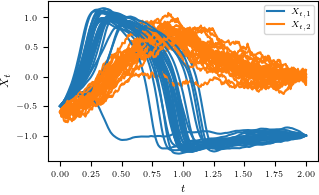

In [146]:
guided_solver = SDESolver(guided_sde, method='milstein')
ts = jnp.linspace(0., 2., 400+1)

guided_traj = guided_solver.batch_solve(jr.PRNGKey(42), x0, ts, 30)

fig, ax = plt.subplots()
for i in range(guided_traj.shape[0]):
    ax.plot(ts, guided_traj[i, :, 0], color='C0')
    ax.plot(ts, guided_traj[i, :, 1], color='C1')
ax.plot([], [], color='C0', label=r'$X_{t, 1}$')
ax.plot([], [], color='C1', label=r'$X_{t, 2}$')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
ax.legend()
fig.savefig("../assets/figures/fhn/guided_normal.pdf")

In [104]:
load(neural_bridge, "../assets/ckpts/neural_bridge/fhn/chi_0.1_s_0.0_gamma_1.5_alpha_0.8_sigma_0.3_vT_-1.0")

Loaded latest model from step 10000


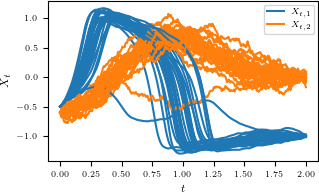

In [115]:
nb_solver = SDESolver(neural_bridge, method='milstein')
ts = jnp.linspace(0., 2., 400+1)
nb_traj = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, 30)

fig, ax = plt.subplots()
for i in range(nb_traj.shape[0]):
    ax.plot(ts, nb_traj[i, :, 0], color='C0')
    ax.plot(ts, nb_traj[i, :, 1], color='C1')
ax.plot([], [], color='C0', label=r'$X_{t, 1}$')
ax.plot([], [], color='C1', label=r'$X_{t, 2}$')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
ax.legend()
fig.savefig("../assets/figures/fhn/normal.pdf")

In [102]:
pcn_sampler = PCNSampler(guided_sde, eta=0.0)

pcn_traj_normal, lls_normal = pcn_sampler.sample(
    x0, ts, n_iters=50000, n_samples=30, n_burn_in=20000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 50000/50000 [00:42<00:00, 1172.92it/s]

acceptance rate (post-burn-in): 64.14%


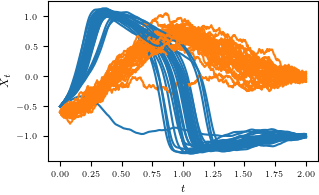

In [116]:
fig, ax = plt.subplots()
for i in range(pcn_traj_normal.shape[0]):
    ax.plot(ts, pcn_traj_normal[i, :, 0], color='C0')
    ax.plot(ts, pcn_traj_normal[i, :, 1], color='C1')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
# ax.legend()
fig.savefig("../assets/figures/fhn/pcn_normal.pdf")

In [109]:
sde_solver = SDESolver(sde, method='milstein')
sde_traj_many = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 10000)
x1_mask = (sde_traj_many[:, -1, 0] >= vT - 1e-2) & (sde_traj_many[:, -1, 0] <= vT + 1e-2)
final_mask = x1_mask
sde_traj_filtered = sde_traj_many[final_mask]
print(f"Found {sde_traj_filtered.shape[0]} samples that satisfy the endpoint conditions out of {sde_traj_many.shape[0]}")

Found 450 samples that satisfy the endpoint conditions out of 10000


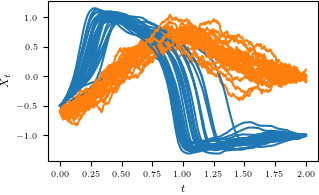

In [117]:
fig, ax = plt.subplots()
for i in range(30):
    ax.plot(ts, sde_traj_filtered[i, :, 0], color='C0')
    ax.plot(ts, sde_traj_filtered[i, :, 1], color='C1')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
# ax.legend()
fig.savefig("../assets/figures/fhn/reference_normal.pdf")

Conditioned on rare event $[1.1]$

In [191]:
rngs = nnx.Rngs(42)
x0 = jnp.array([-0.5, -0.6])
vT = jnp.array([1.1])

T = 2.0
chi = 0.1
s = 0.0
gamma = 1.5
alpha = 0.8
sigma = 0.3

sde, aux_sde, guided_sde, neural_bridge = construct_sdes(chi, s, gamma, alpha, sigma, vT, T, rngs)

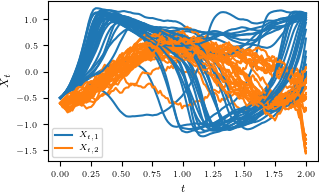

In [192]:
guided_solver = SDESolver(guided_sde, method='milstein')
ts = jnp.linspace(0., 2., 200 + 1, endpoint=True)
ts = ts * (2. - ts / T)

guided_traj = guided_solver.batch_solve(jr.PRNGKey(4), x0, ts, 30)

fig, ax = plt.subplots()
for i in range(guided_traj.shape[0]):
    ax.plot(ts, guided_traj[i, :, 0], color='C0')
    ax.plot(ts, guided_traj[i, :, 1], color='C1')
ax.plot([], [], color='C0', label=r'$X_{t, 1}$')
ax.plot([], [], color='C1', label=r'$X_{t, 2}$')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
ax.legend()
fig.savefig("../assets/figures/fhn/guided_rare.pdf")

In [200]:
load(neural_bridge, "../assets/ckpts/neural_bridge/fhn/chi_0.1_s_0.0_gamma_1.5_alpha_0.8_sigma_0.3_vT_1.1")

Loaded latest model from step 5000


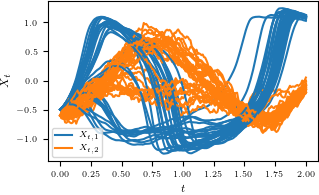

In [202]:
nb_solver = SDESolver(neural_bridge, method='milstein')
ts = jnp.linspace(0., 2., 200+1)
nb_traj = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, 30)

fig, ax = plt.subplots()
for i in range(nb_traj.shape[0]):
    ax.plot(ts, nb_traj[i, :, 0], color='C0')
    ax.plot(ts, nb_traj[i, :, 1], color='C1')
ax.plot([], [], color='C0', label=r'$X_{t, 1}$')
ax.plot([], [], color='C1', label=r'$X_{t, 2}$')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
ax.legend()
fig.savefig("../assets/figures/fhn/rare.pdf")

In [195]:
pcn_sampler = PCNSampler(guided_sde, eta=0.9)

pcn_traj_normal, lls_normal = pcn_sampler.sample(
    x0, ts, n_iters=50000, n_samples=30, n_burn_in=20000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 50000/50000 [00:43<00:00, 1155.72it/s]

acceptance rate (post-burn-in): 22.46%


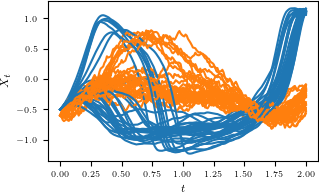

In [203]:
fig, ax = plt.subplots()
for i in range(pcn_traj_normal.shape[0]):
    ax.plot(ts, pcn_traj_normal[i, :, 0], color='C0')
    ax.plot(ts, pcn_traj_normal[i, :, 1], color='C1')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
# ax.legend()
fig.savefig("../assets/figures/fhn/pcn_rare.pdf")

In [198]:
sde_solver = SDESolver(sde, method='milstein')
sde_traj_many = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 200000)
x1_mask = (sde_traj_many[:, -1, 0] >= vT - 1e-2) & (sde_traj_many[:, -1, 0] <= vT + 1e-2)
final_mask = x1_mask
sde_traj_filtered = sde_traj_many[final_mask]
print(f"Found {sde_traj_filtered.shape[0]} samples that satisfy the endpoint conditions out of {sde_traj_many.shape[0]}")

Found 35 samples that satisfy the endpoint conditions out of 200000


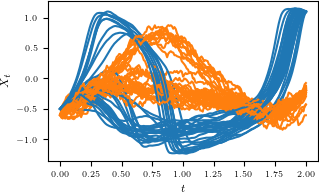

In [204]:
fig, ax = plt.subplots()
for i in range(30):
    ax.plot(ts, sde_traj_filtered[-i, :, 0], color='C0')
    ax.plot(ts, sde_traj_filtered[-i, :, 1], color='C1')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_t$')
# ax.legend()
fig.savefig("../assets/figures/fhn/reference_rare.pdf")

In [205]:
print(f"{35 / 200000:.2%}")

0.02%
